# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder

from itertools import combinations
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Load Dataset

In [2]:
# Read csv file
df = pd.read_csv("data.csv")

# Basic Data Exploration

In [3]:
# 1. Show first few entries
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# 2. Show random 10 entries
df.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
187924,553013,20725,LUNCH BAG RED RETROSPOT,2,5/12/2011 18:19,4.13,NaN,United Kingdom
483605,577504,21558,SKULL LUNCH BOX WITH CUTLERY,4,11/20/2011 12:36,2.55,14159.0,United Kingdom
496657,578347,21704,BAG 250g SWIRLY MARBLES,1,11/24/2011 9:26,1.63,NaN,United Kingdom
429239,573548,23322,LARGE WHITE HEART OF WICKER,3,10/31/2011 13:22,2.95,13680.0,United Kingdom
202967,554511,21988,PACK OF 6 SKULL PAPER PLATES,1,5/24/2011 15:52,1.63,NaN,United Kingdom
302543,563436,22624,IVORY KITCHEN SCALES,2,8/16/2011 12:32,8.50,16131.0,United Kingdom
383904,570092,21931,JUMBO STORAGE BAG SUKI,100,10/7/2011 11:51,1.74,16029.0,United Kingdom
169855,551268,22719,GUMBALL MONOCHROME COAT RACK,1,4/27/2011 12:08,1.25,16965.0,United Kingdom
489102,577919,47503A,ASS FLORAL PRINT MULTI SCREWDRIVER,1,11/22/2011 11:58,0.42,17075.0,United Kingdom
309015,564060,22070,SMALL RED RETROSPOT MUG IN BOX,1,8/22/2011 14:37,3.75,17073.0,United Kingdom


In [5]:
# 3. Describe datasets
print("\nSummary Statistics:")
df.describe()


Summary Statistics:


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
# 4. Dataset columns and shapes
print("\nDataset Columns:")
print(df.columns)

print(f"Dataset shape: {df.shape}")


Dataset Columns:
Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')
Dataset shape: (541909, 8)


In [7]:
# 5. Check missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [8]:
# 6. Check duplicate values
print("\nChecking for duplicate rows:")
print(f"Duplicate rows: {df.duplicated().sum()}")


Checking for duplicate rows:
Duplicate rows: 5268


# Data Preprocessing

In [9]:
# 4.1. Check cancelled transactions
df[df['InvoiceNo'].astype(str).str.startswith('C')].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


In [10]:
# 4.2 Drop missing or invalid rows
df = df.dropna(subset=['Description', 'InvoiceNo'])         #Remove rows with missing Description or InvoiceNo
df = df[df['Quantity'] > 0]                                 # Remove rows with negative or zero quantity
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]   # Remove credit note transactions (invoices starting with 'C')
df = df[df['Country'] == 'United Kingdom']                  # Filter for transactions in the United Kingdom only (most frequent)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])       # Convert InvoiceDate to datetime

In [11]:
# 4.3. Comparison sample of before transformation and after cleaning
#Sample before transformation
before_sample = df.head(5)

#Sample after cleaning
after_sample = df.head(5)

before_sample, after_sample

(  InvoiceNo StockCode                          Description  Quantity  \
 0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1    536365     71053                  WHITE METAL LANTERN         6   
 2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
 3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
 4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
 
           InvoiceDate  UnitPrice  CustomerID         Country  
 0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
 1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
 2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
 3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
 4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  ,
   InvoiceNo StockCode                          Description  Quantity  \
 0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1    536365     71053       

# Transaction Format for Apriori

In [12]:
# 4.4 Create the Basket Matrix
basket = (df.groupby(['InvoiceNo', 'Description'])['Quantity']  #Handles duplicate values by grouping InvoiceNo and Description, then summed quantities
            .sum().unstack().reset_index().fillna(0)
            .set_index('InvoiceNo'))

basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

# Show a sample of the final transaction matrix
basket_sets.head()

C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\3095584677.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)


Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# 4.5 Limit Basket to Top 100 Items (to manage memory)
top_items = basket_sets.sum().sort_values(ascending=False).head(100).index
basket_small = basket_sets[top_items]

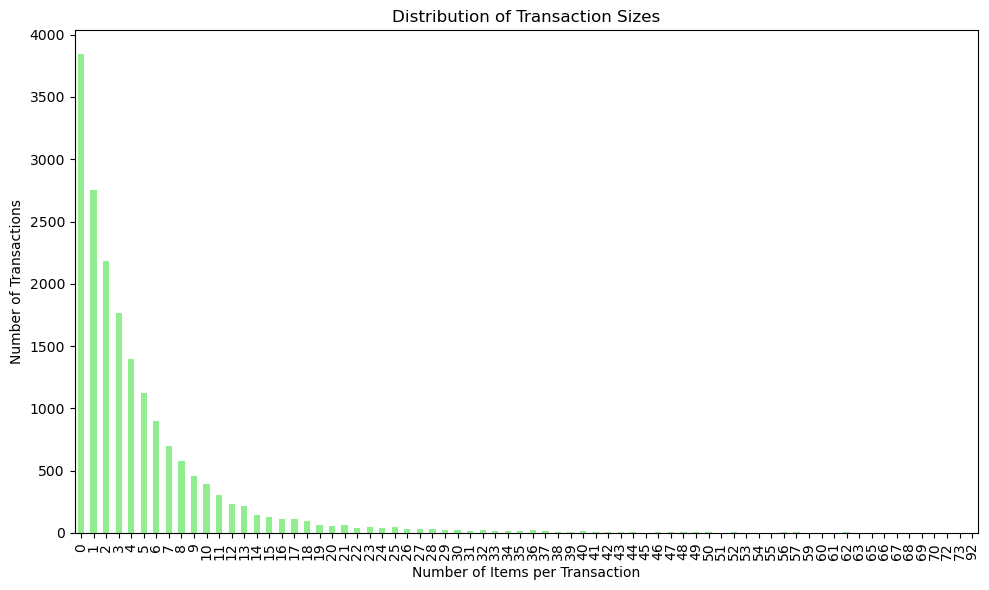

In [14]:
# 4.6 Plot Distribution of Transaction Sizes
transaction_sizes = basket_small.sum(axis=1)
plt.figure(figsize=(10, 6))
transaction_sizes.value_counts().sort_index().plot(kind='bar', color='lightgreen')
plt.title("Distribution of Transaction Sizes")
plt.xlabel("Number of Items per Transaction")
plt.ylabel("Number of Transactions")
plt.tight_layout()
plt.show()

# 1. APRIORI ALGORITHM

In [20]:
frequent_itemsets = apriori(basket_small, min_support=0.02, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False).head(10)

C:\Users\Asus\anaconda3\New folder\New folder\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.119050,(WHITE HANGING HEART T-LIGHT HOLDER)
1,0.106519,(JUMBO BAG RED RETROSPOT)
2,0.092613,(REGENCY CAKESTAND 3 TIER)
3,0.087611,(PARTY BUNTING)
4,0.076509,(LUNCH BAG RED RETROSPOT)
5,0.075355,(ASSORTED COLOUR BIRD ORNAMENT)
6,0.068209,(SET OF 3 CAKE TINS PANTRY DESIGN )
7,0.067000,(NATURAL SLATE HEART CHALKBOARD )
8,0.066835,(LUNCH BAG BLACK SKULL.)
9,0.063977,(HEART OF WICKER SMALL)


## Generate Association Rules

In [119]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=3)
rules_apriori = association_rules(frequent_itemsets, metric="lift", min_threshold=3)
rules_apriori['rule'] = rules_apriori['antecedents'].apply(lambda x: ', '.join(x)) + " → " + rules_apriori['consequents'].apply(lambda x: ', '.join(x))

In [121]:
print(len(rules_apriori))

190


In [120]:
print("\Top 10 Apriori Rules")
rules_apriori[['rule', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10)

\Top 10 Apriori Rules


<>:1: DeprecationWarning: invalid escape sequence '\T'
<>:1: DeprecationWarning: invalid escape sequence '\T'
C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\3134217721.py:1: DeprecationWarning: invalid escape sequence '\T'
  print("\Top 10 Apriori Rules")


,rule,support,confidence,lift
187,PINK REGENCY TEACUP AND SAUCER → GREEN REGENCY...,0.027097,0.701280,18.201273
186,"GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.027097,0.703281,18.201273
188,GREEN REGENCY TEACUP AND SAUCER → PINK REGENCY...,0.027097,0.527837,17.588775
185,"PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY ...",0.027097,0.902930,17.588775
184,"PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY ...",0.027097,0.854419,16.243790
189,ROSES REGENCY TEACUP AND SAUCER → PINK REGENC...,0.027097,0.515152,16.243790
137,GREEN REGENCY TEACUP AND SAUCER → PINK REGENCY...,0.031714,0.617773,15.988282
136,PINK REGENCY TEACUP AND SAUCER → GREEN REGENCY...,0.031714,0.820768,15.988282
162,DOLLY GIRL LUNCH BOX → SPACEBOY LUNCH BOX,0.023414,0.609442,15.817673
163,SPACEBOY LUNCH BOX → DOLLY GIRL LUNCH BOX,0.023414,0.607703,15.817673


C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\287654081.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='lift', y='rule', data=top_apriori_rules, palette='mako')


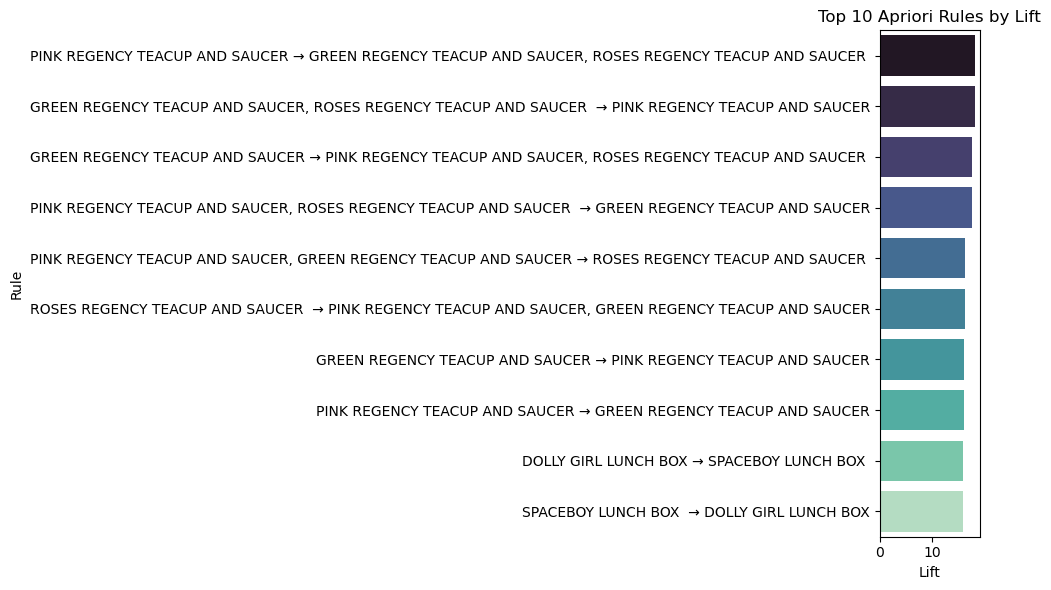

In [56]:
top_apriori_rules = rules_apriori.sort_values(by='lift', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='lift', y='rule', data=top_apriori_rules, palette='mako')
plt.title('Top 10 Apriori Rules by Lift')
plt.xlabel('Lift')
plt.ylabel('Rule')
plt.tight_layout()
plt.show()

## Top 10 Products Sold

In [25]:
top_products = df['Description'].value_counts().head(10)
print("\nTop 10 Products Sold:")
print(top_products)


Top 10 Products Sold:
Description
WHITE HANGING HEART T-LIGHT HOLDER    2231
JUMBO BAG RED RETROSPOT               1960
REGENCY CAKESTAND 3 TIER              1711
PARTY BUNTING                         1615
LUNCH BAG RED RETROSPOT               1421
ASSORTED COLOUR BIRD ORNAMENT         1405
LUNCH BAG  BLACK SKULL.               1271
SET OF 3 CAKE TINS PANTRY DESIGN      1255
NATURAL SLATE HEART CHALKBOARD        1233
HEART OF WICKER SMALL                 1188
Name: count, dtype: int64


## Top 10 Most Frequent Items (Visualization)

C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\1111896833.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=item_counts.values, y=item_counts.index, palette='Blues_d')


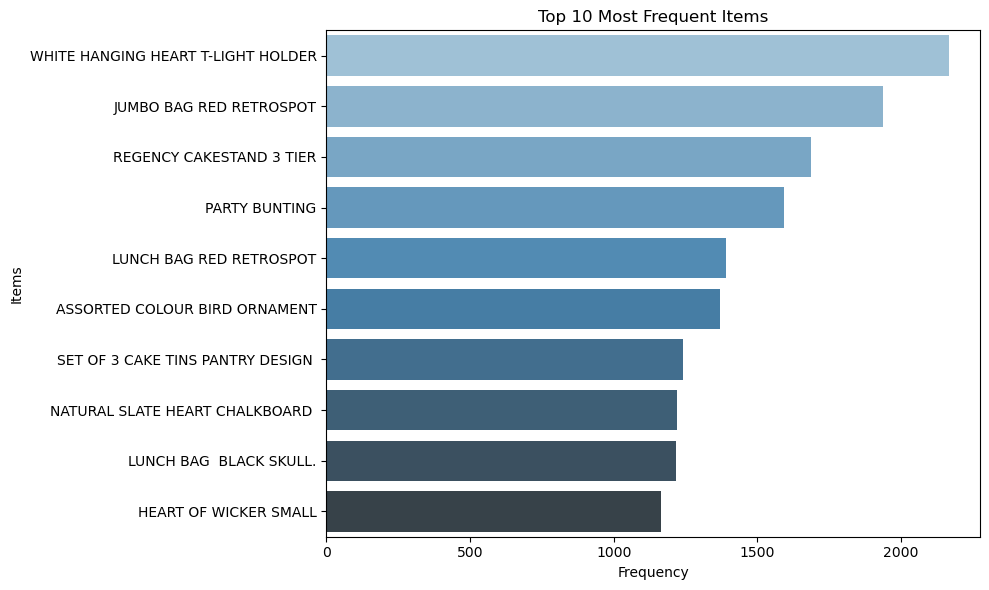

In [26]:
item_counts = basket_small.sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=item_counts.values, y=item_counts.index, palette='Blues_d')
plt.title('Top 10 Most Frequent Items')
plt.xlabel('Frequency')
plt.ylabel('Items')
plt.tight_layout()
plt.show()

## Bottom 10 Least Frequent Items

In [27]:
least_products = df['Description'].value_counts().tail(10)
print("\nLeast 10 Products Sold:")
print(least_products)


Least 10 Products Sold:
Description
GLASS BEAD HOOP NECKLACE BLACK         1
DOLPHIN WINDMILL                       1
WHITE FRANGIPANI HAIR CLIP             1
BAROQUE BUTTERFLY EARRINGS MONTANA     1
ZINC STAR T-LIGHT HOLDER               1
incorrectly credited C550456 see 47    1
CAPIZ CHANDELIER                       1
16 PC CUTLERY SET PANTRY DESIGN        1
LILY BROOCH WHITE/SILVER COLOUR        1
PAPER CRAFT , LITTLE BIRDIE            1
Name: count, dtype: int64


## Bottom 10 Least Frequent Items (Visualization)

C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\512421342.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=least_10.values, y=least_10.index, palette='Reds_r')


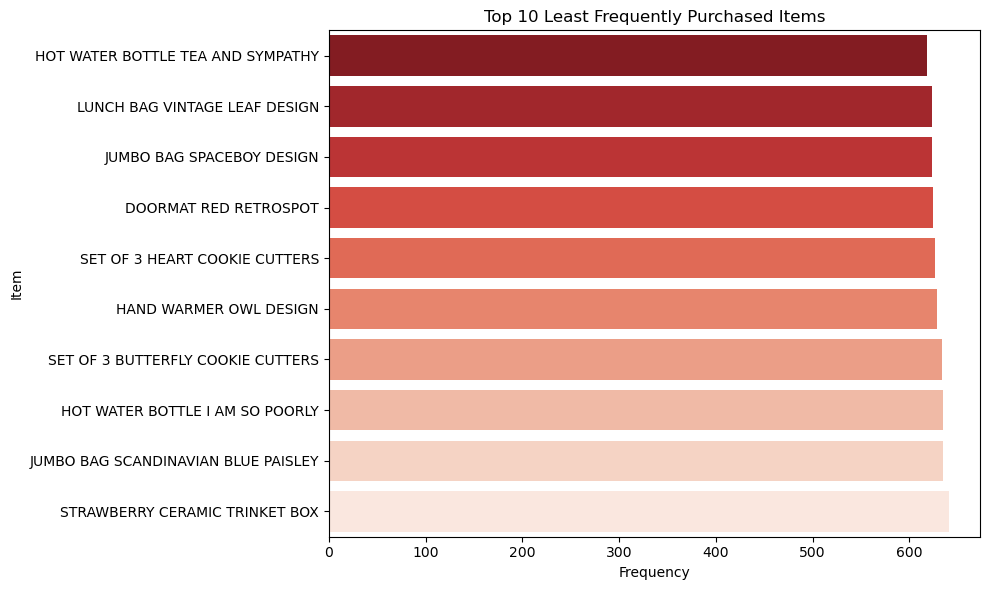

In [28]:
# Least frequent items visualization
plt.figure(figsize=(10, 6))
least_10 = basket_small.sum().sort_values(ascending=True).head(10)
sns.barplot(x=least_10.values, y=least_10.index, palette='Reds_r')
plt.title('Top 10 Least Frequently Purchased Items')
plt.xlabel('Frequency')
plt.ylabel('Item')
plt.tight_layout()
plt.show()

## Scatter Plot of Rules (Support vs Confidence)

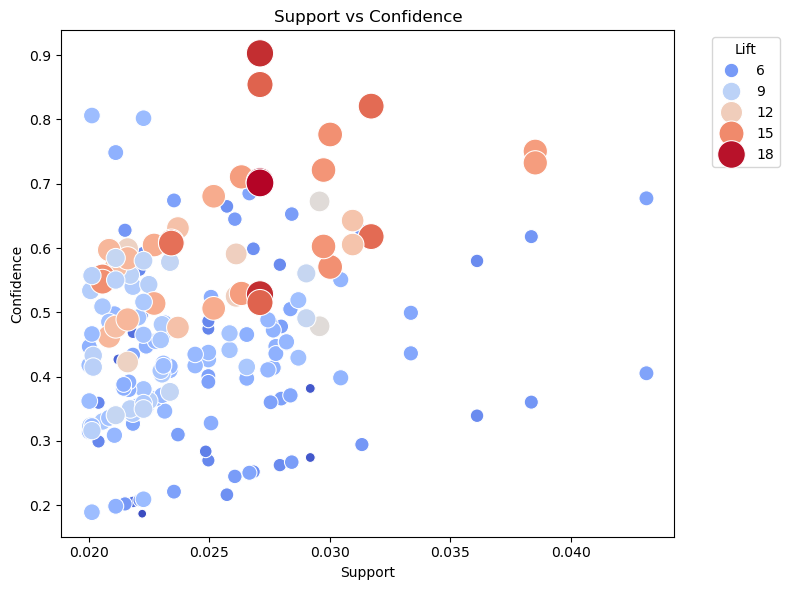

In [29]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='support', y='confidence', size='lift', hue='lift',
                data=rules, palette='coolwarm', sizes=(40, 400))
plt.title('Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.legend(title='Lift', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Network Graph of Rules


Creating rule network graph:


C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\1900989526.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


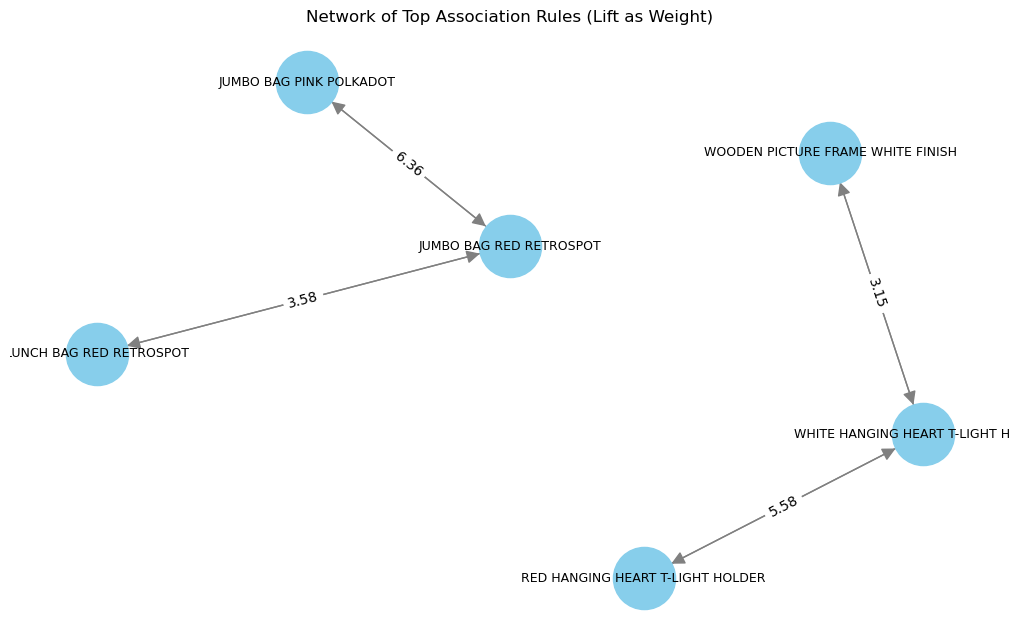

In [37]:
print("\nCreating rule network graph:")
G = nx.DiGraph()

# Filter top simple 1-to-1 rules for less clutter
simple_rules = rules[
    rules['antecedents'].apply(lambda x: len(x) == 1) &
    rules['consequents'].apply(lambda x: len(x) == 1)
].head(8).copy()

# Flatten frozensets for readability
simple_rules['antecedents'] = simple_rules['antecedents'].apply(lambda x: next(iter(x)))
simple_rules['consequents'] = simple_rules['consequents'].apply(lambda x: next(iter(x)))

# Add edges to graph
for _, row in simple_rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['lift'])

# Draw network
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42, k=2.5)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray',
        node_size=2000, font_size=9, arrowsize=20)

# Add edge labels (lift)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()})

plt.title("Network of Top Association Rules (Lift as Weight)")
plt.tight_layout()
plt.show()

## Show Top 10 Rules Table

In [97]:
print("🔹 Top 10 Association Rules (Apriori):")
top_apriori = rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(
    by='lift', ascending=False).head(10
print(top_apriori.to_string(index=False))

🔹 Top 10 Association Rules (Apriori):
                                                        antecedents                                                         consequents  support  confidence      lift
                                   (PINK REGENCY TEACUP AND SAUCER) (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER ) 0.027097    0.701280 18.201273
(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER )                                    (PINK REGENCY TEACUP AND SAUCER) 0.027097    0.703281 18.201273
                                  (GREEN REGENCY TEACUP AND SAUCER)  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER ) 0.027097    0.527837 17.588775
 (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER )                                   (GREEN REGENCY TEACUP AND SAUCER) 0.027097    0.902930 17.588775
  (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY TEACUP AND SAUCER)                                  (ROSES REGENCY TEACUP AND 

# 2. FP-GROWTH

##  Top 10 Most Sold Products (by Total Quantity)

In [65]:
top_quantity_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

print("\nTop 10 Most Sold Products (by Total Quantity):")
print(top_quantity_products)


Top 10 Most Sold Products (by Total Quantity):
Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77036
WORLD WAR 2 GLIDERS ASSTD DESIGNS     49526
JUMBO BAG RED RETROSPOT               44268
WHITE HANGING HEART T-LIGHT HOLDER    35744
POPCORN HOLDER                        34738
ASSORTED COLOUR BIRD ORNAMENT         33735
PACK OF 12 LONDON TISSUES             25331
PACK OF 72 RETROSPOT CAKE CASES       24986
VICTORIAN GLASS HANGING T-LIGHT       23692
Name: Quantity, dtype: int64


## Top 10 Most Sold Products (Total Quantity)

C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\1494272608.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sold.values, y=top_sold.index, palette='Greens_r')


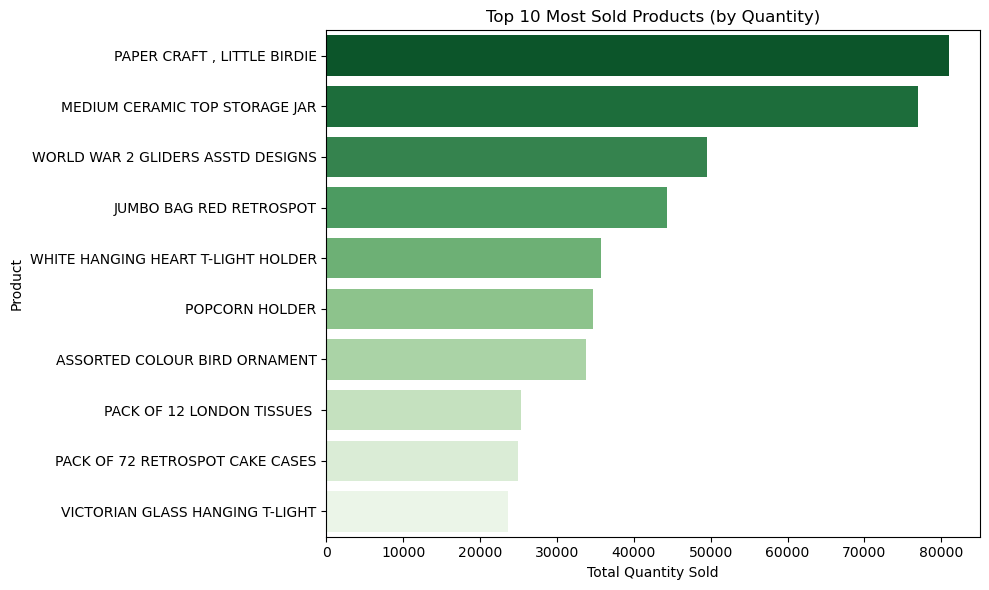

In [63]:
top_sold = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_sold.values, y=top_sold.index, palette='Greens_r')
plt.title('Top 10 Most Sold Products (by Quantity)')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

## Top 10 Most Frequent Items (FP-Growth)

In [67]:
top_fp_items = basket_small.sum().sort_values(ascending=False).head(10)

print("\nTop 10 Most Frequent Items in Transactions (FP-Growth):")
print(top_fp_items)


Top 10 Most Frequent Items in Transactions (FP-Growth):
Description
WHITE HANGING HEART T-LIGHT HOLDER    2166
JUMBO BAG RED RETROSPOT               1938
REGENCY CAKESTAND 3 TIER              1685
PARTY BUNTING                         1594
LUNCH BAG RED RETROSPOT               1392
ASSORTED COLOUR BIRD ORNAMENT         1371
SET OF 3 CAKE TINS PANTRY DESIGN      1241
NATURAL SLATE HEART CHALKBOARD        1219
LUNCH BAG  BLACK SKULL.               1216
HEART OF WICKER SMALL                 1164
dtype: int64


## Top 10 Most Frequent Items in Transactions (for FP-Growth)

C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\1510731207.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=item_frequency.values, y=item_frequency.index, palette='Blues_d')


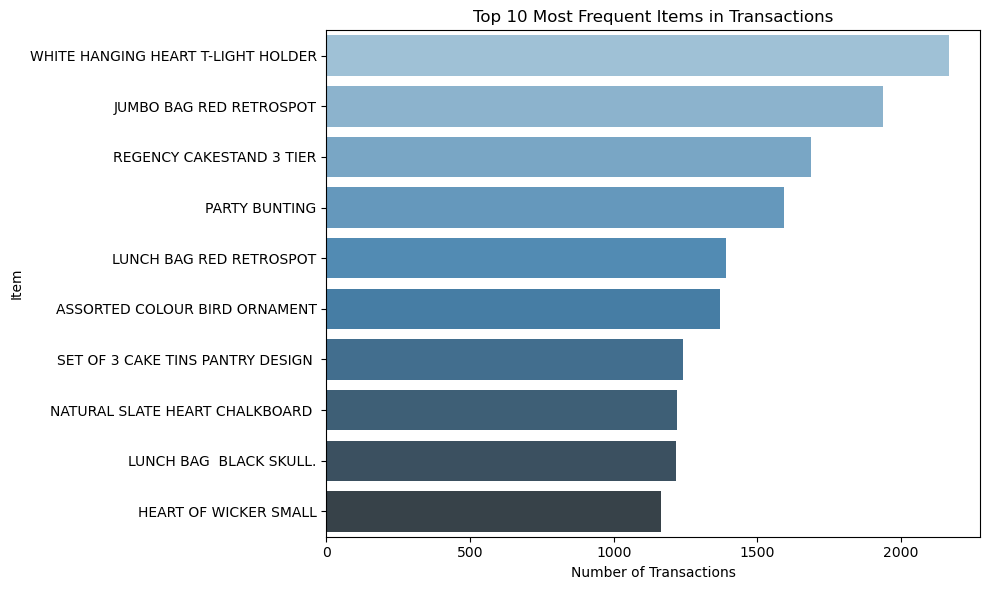

In [64]:
item_frequency = basket_small.sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=item_frequency.values, y=item_frequency.index, palette='Blues_d')
plt.title('Top 10 Most Frequent Items in Transactions')
plt.xlabel('Number of Transactions')
plt.ylabel('Item')
plt.tight_layout()
plt.show()

## Top 10 Least Frequent Items (FP-Growth Transactions)

In [60]:
least_fp_items = basket_small.sum().sort_values(ascending=True).head(10)

print("\nTop 10 Least Frequent Items in Transactions (FP-Growth):")
print(least_fp_items)


Top 10 Least Frequent Items in Transactions (FP-Growth):
Description
HOT WATER BOTTLE TEA AND SYMPATHY      618
LUNCH BAG VINTAGE LEAF DESIGN          623
JUMBO BAG SPACEBOY DESIGN              623
DOORMAT RED RETROSPOT                  624
SET OF 3 HEART COOKIE CUTTERS          627
HAND WARMER OWL DESIGN                 629
SET OF 3 BUTTERFLY COOKIE CUTTERS      634
HOT WATER BOTTLE I AM SO POORLY        635
JUMBO BAG SCANDINAVIAN BLUE PAISLEY    635
STRAWBERRY CERAMIC TRINKET BOX         641
dtype: int64


## Top 10 Least Frequent Items in Transactions (FP-Growth)

C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\3580900578.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=least_frequent.values, y=least_frequent.index, palette='Reds_r')


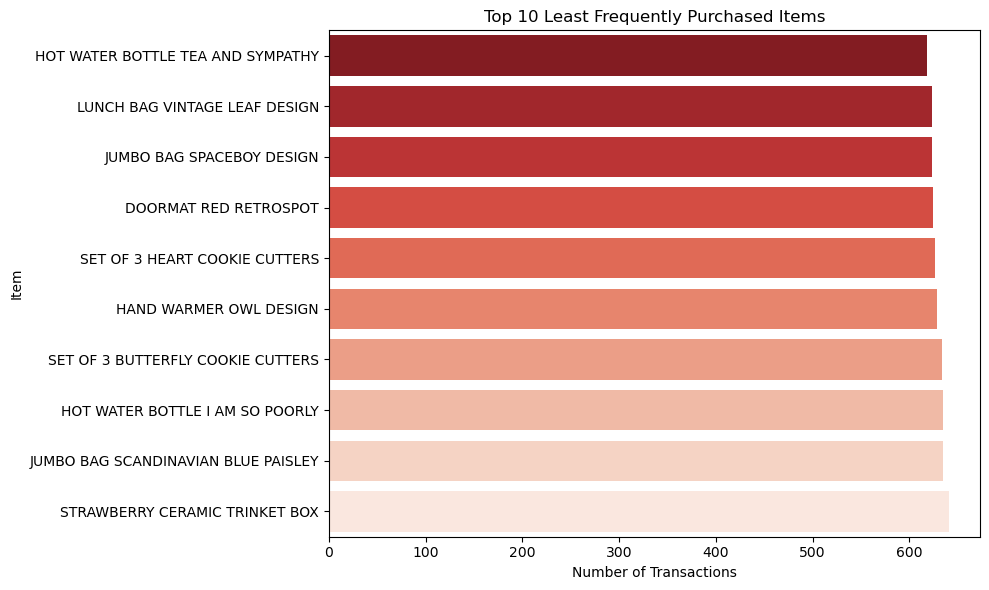

In [69]:
least_frequent = basket_small.sum().sort_values(ascending=True).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=least_frequent.values, y=least_frequent.index, palette='Reds_r')
plt.title('Top 10 Least Frequently Purchased Items')
plt.xlabel('Number of Transactions')
plt.ylabel('Item')
plt.tight_layout()
plt.show()

In [46]:
#Apply FP-Growth
frequent_itemsets_fp = fpgrowth(basket_sets, min_support=0.015, use_colnames=True)

C:\Users\Asus\anaconda3\New folder\New folder\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [47]:
#Generate association rules
rules_fp = association_rules(frequent_itemsets_fp, metric="confidence", min_threshold=0.5)

In [92]:
print(len(rules_fp))

209


In [48]:
# Format rules for display
rules_fp['Rule'] = rules_fp['antecedents'].apply(lambda x: ' + '.join(sorted(x))) + \
                   ' → ' + \
                   rules_fp['consequents'].apply(lambda x: ' + '.join(sorted(x)))

# Display top rules
rules_fp[['Rule', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10)

,Rule,support,confidence,lift
202,REGENCY TEA PLATE GREEN → REGENCY TEA PLATE R...,0.015445,0.836310,39.936524
203,REGENCY TEA PLATE ROSES → REGENCY TEA PLATE G...,0.015445,0.737533,39.936524
163,SMALL MARSHMALLOWS PINK BOWL → SMALL DOLLY MIX...,0.018413,0.779070,27.792932
164,SMALL DOLLY MIX DESIGN ORANGE BOWL → SMALL MAR...,0.018413,0.656863,27.792932
157,WOODEN HEART CHRISTMAS SCANDINAVIAN → WOODEN S...,0.020226,0.722986,27.461402
158,WOODEN STAR CHRISTMAS SCANDINAVIAN → WOODEN HE...,0.020226,0.768267,27.461402
85,TOILET METAL SIGN → BATHROOM METAL SIGN,0.015829,0.729114,21.499998
43,CHARLOTTE BAG SUKI DESIGN + STRAWBERRY CHARLOT...,0.015774,0.730280,19.453459
42,RED RETROSPOT CHARLOTTE BAG + WOODLAND CHARLOT...,0.016764,0.707657,19.130913
150,CHARLOTTE BAG PINK POLKADOT + CHARLOTTE BAG SU...,0.015115,0.716146,19.076951


##  Bar Plot of FP-Growth Rules by Lift

C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\2013412249.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='lift', y='Rule', data=top_rules, palette='viridis')


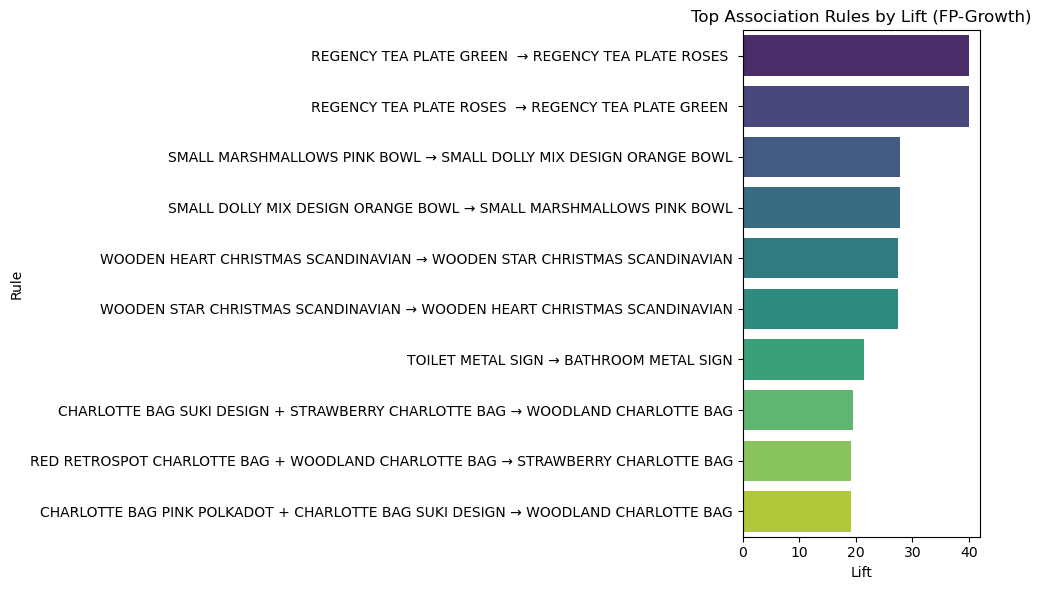

In [51]:
# Sort and select top N rules
top_rules = rules_fp.sort_values(by='lift', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='lift', y='Rule', data=top_rules, palette='viridis')
plt.title('Top Association Rules by Lift (FP-Growth)')
plt.xlabel('Lift')
plt.ylabel('Rule')
plt.tight_layout()
plt.show()

## Support vs Confidence (FP-Growth)

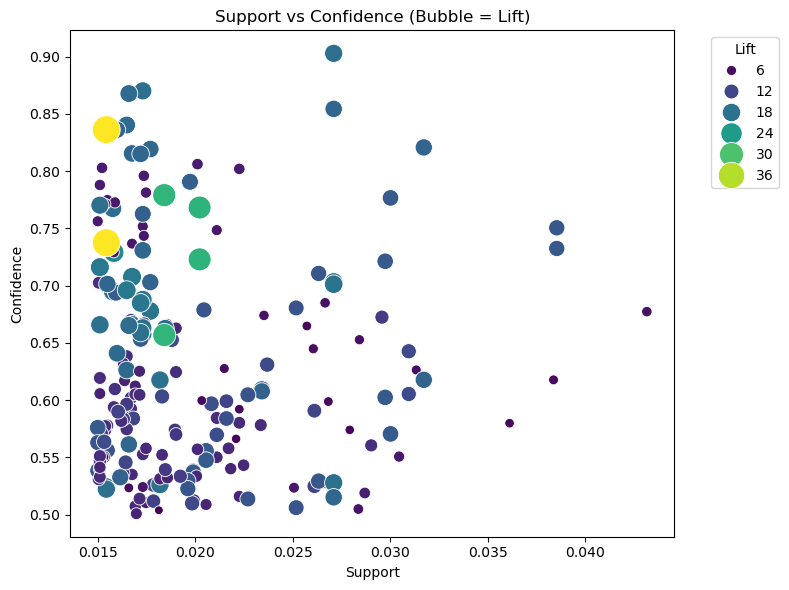

In [52]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rules_fp, x='support', y='confidence', size='lift', hue='lift', sizes=(40, 400), palette='viridis')
plt.title("Support vs Confidence (Bubble = Lift)")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.legend(title="Lift", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Creating FP-Growth rule network graph:


C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\3390234249.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


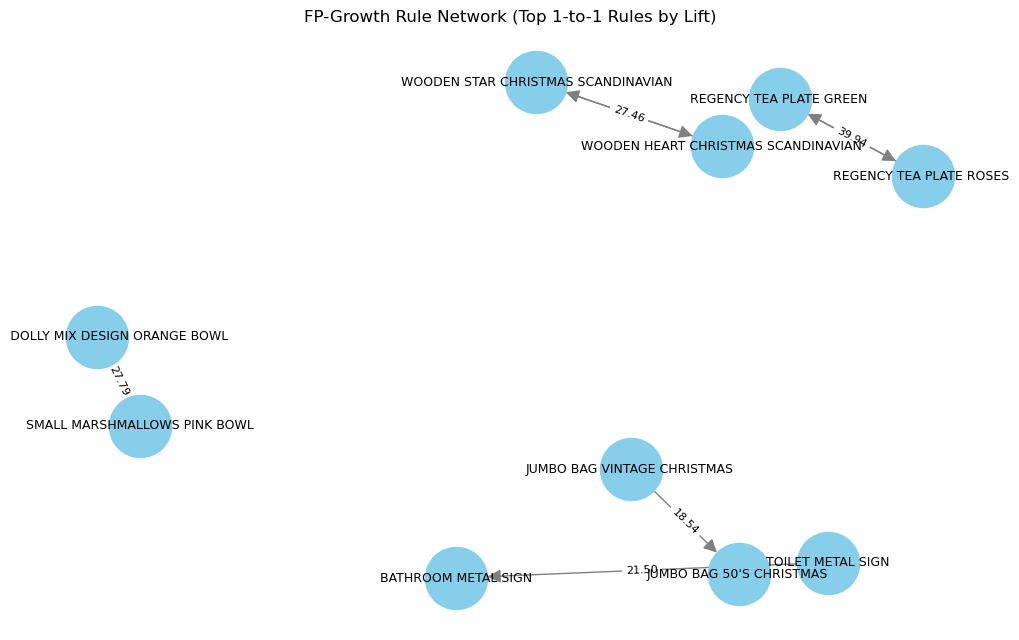

In [105]:
print("\nCreating FP-Growth rule network graph:")

# Create directed graph
G = nx.DiGraph()

# Convert frozensets to strings for matching and filtering
rules_fp['antecedents_str'] = rules_fp['antecedents'].apply(lambda x: ', '.join(sorted(x)))
rules_fp['consequents_str'] = rules_fp['consequents'].apply(lambda x: ', '.join(sorted(x)))

# Filter only simple 1-to-1 rules (no commas = single item)
simple_rules_fp = rules_fp[
    (rules_fp['antecedents_str'].str.count(',') == 0) &
    (rules_fp['consequents_str'].str.count(',') == 0)
].sort_values(by='lift', ascending=False).head(8).copy()

# Add edges with lift as weight
for _, row in simple_rules_fp.iterrows():
    G.add_edge(row['antecedents_str'], row['consequents_str'], weight=row['lift'])

# Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42, k=2.5)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='skyblue',
    edge_color='gray',
    node_size=2000,
    font_size=9,
    arrowsize=20
)

# Add edge labels (lift values)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels={k: f"{v:.2f}" for k, v in labels.items()},
    font_size=8
)

plt.title("FP-Growth Rule Network (Top 1-to-1 Rules by Lift)")
plt.tight_layout()
plt.show()


In [100]:
print("Top 10 Association Rules (FP-Growth):")
top_fp = rules_fp[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(
    by='lift', ascending=False).head(10)
print(top_fp.to_string(index=False))

Top 10 Association Rules (FP-Growth):
                                             antecedents                           consequents  support  confidence      lift
                              (REGENCY TEA PLATE GREEN )            (REGENCY TEA PLATE ROSES ) 0.015445    0.836310 39.936524
                              (REGENCY TEA PLATE ROSES )            (REGENCY TEA PLATE GREEN ) 0.015445    0.737533 39.936524
                          (SMALL MARSHMALLOWS PINK BOWL)  (SMALL DOLLY MIX DESIGN ORANGE BOWL) 0.018413    0.779070 27.792932
                    (SMALL DOLLY MIX DESIGN ORANGE BOWL)        (SMALL MARSHMALLOWS PINK BOWL) 0.018413    0.656863 27.792932
                   (WOODEN HEART CHRISTMAS SCANDINAVIAN)  (WOODEN STAR CHRISTMAS SCANDINAVIAN) 0.020226    0.722986 27.461402
                    (WOODEN STAR CHRISTMAS SCANDINAVIAN) (WOODEN HEART CHRISTMAS SCANDINAVIAN) 0.020226    0.768267 27.461402
                                     (TOILET METAL SIGN)                 (BATHRO

# 3. BRUTE FORCE

## Top 10 Most Sold Products (by Quantity) — Brute Force


[Brute Force] Top 10 Most Sold Products (by Quantity):
Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77036
WORLD WAR 2 GLIDERS ASSTD DESIGNS     49526
JUMBO BAG RED RETROSPOT               44268
WHITE HANGING HEART T-LIGHT HOLDER    35744
POPCORN HOLDER                        34738
ASSORTED COLOUR BIRD ORNAMENT         33735
PACK OF 12 LONDON TISSUES             25331
PACK OF 72 RETROSPOT CAKE CASES       24986
VICTORIAN GLASS HANGING T-LIGHT       23692
Name: Quantity, dtype: int64


C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\3641527489.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_quantity_brute.values, y=top_quantity_brute.index, palette='Greens')


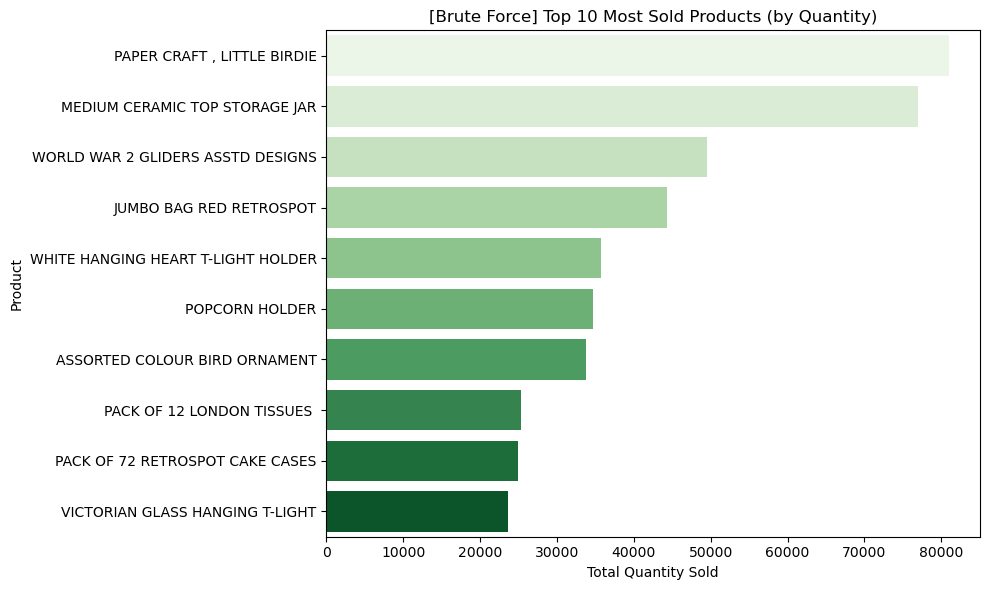

In [79]:
top_quantity_brute = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

print("\n[Brute Force] Top 10 Most Sold Products (by Quantity):")
print(top_quantity_brute)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_quantity_brute.values, y=top_quantity_brute.index, palette='Greens')
plt.title('[Brute Force] Top 10 Most Sold Products (by Quantity)')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product')
plt.tight_layout()
plt.show()


[Brute Force] Top 10 Most Frequently Bought Items:
Description
WHITE HANGING HEART T-LIGHT HOLDER    2166
JUMBO BAG RED RETROSPOT               1938
REGENCY CAKESTAND 3 TIER              1685
PARTY BUNTING                         1594
LUNCH BAG RED RETROSPOT               1392
ASSORTED COLOUR BIRD ORNAMENT         1371
SET OF 3 CAKE TINS PANTRY DESIGN      1241
NATURAL SLATE HEART CHALKBOARD        1219
LUNCH BAG  BLACK SKULL.               1216
HEART OF WICKER SMALL                 1164
dtype: int64


C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\2100501957.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_frequent_brute.values, y=most_frequent_brute.index, palette='Oranges_r')


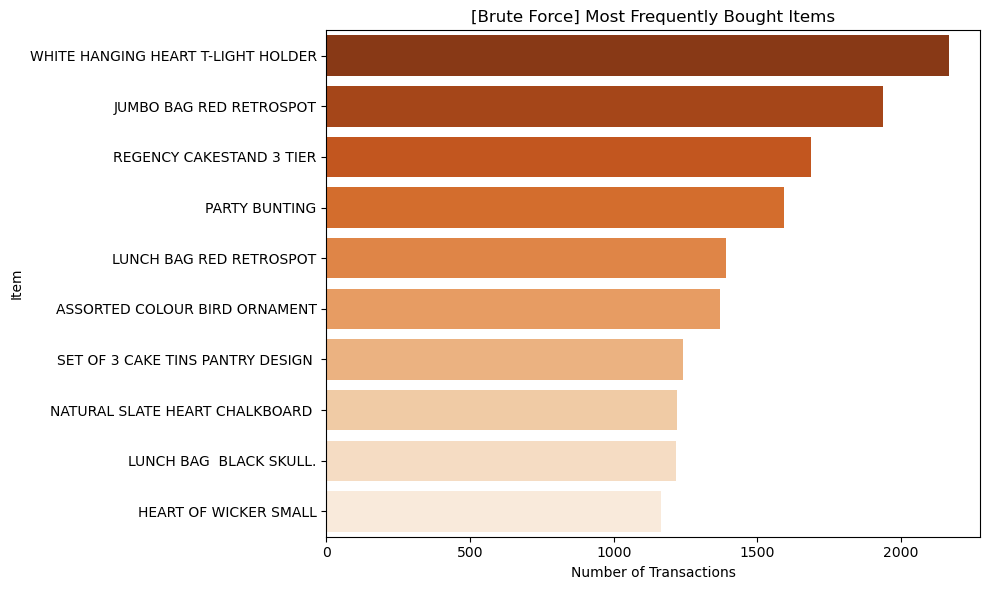

In [82]:
most_frequent_brute = basket_small.sum().sort_values(ascending=False).head(10)

print("\n[Brute Force] Top 10 Most Frequently Bought Items:")
print(most_frequent_brute)

plt.figure(figsize=(10, 6))
sns.barplot(x=most_frequent_brute.values, y=most_frequent_brute.index, palette='Oranges_r')
plt.title('[Brute Force] Most Frequently Bought Items')
plt.xlabel('Number of Transactions')
plt.ylabel('Item')
plt.tight_layout()
plt.show()


[Brute Force] Top 10 Least Frequently Bought Items:
Description
HOT WATER BOTTLE TEA AND SYMPATHY      618
LUNCH BAG VINTAGE LEAF DESIGN          623
JUMBO BAG SPACEBOY DESIGN              623
DOORMAT RED RETROSPOT                  624
SET OF 3 HEART COOKIE CUTTERS          627
HAND WARMER OWL DESIGN                 629
SET OF 3 BUTTERFLY COOKIE CUTTERS      634
HOT WATER BOTTLE I AM SO POORLY        635
JUMBO BAG SCANDINAVIAN BLUE PAISLEY    635
STRAWBERRY CERAMIC TRINKET BOX         641
dtype: int64


C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\3023074531.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=least_frequent_brute.values, y=least_frequent_brute.index, palette='rocket')


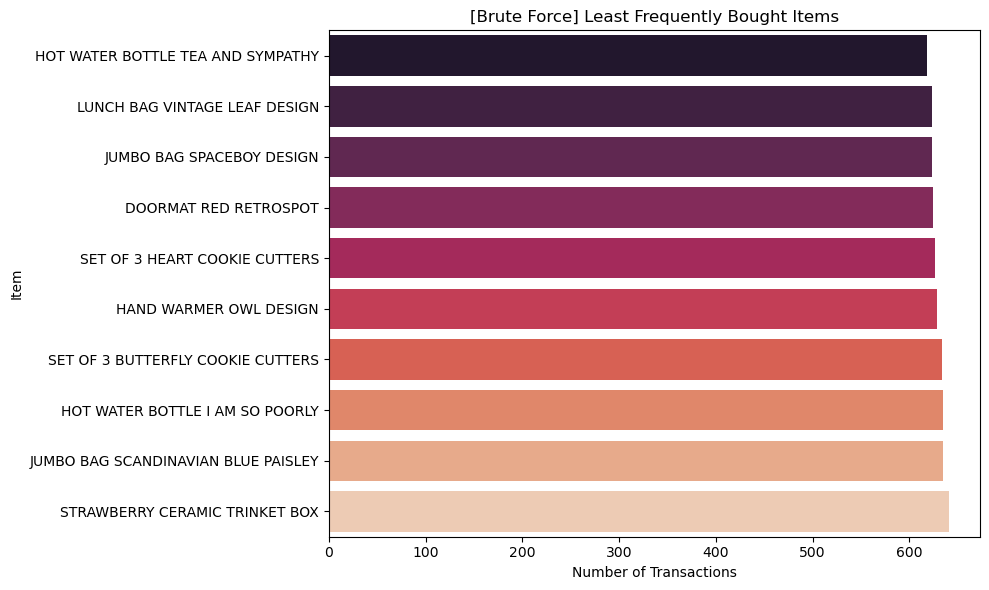

In [81]:
least_frequent_brute = basket_small.sum().sort_values(ascending=True).head(10)

print("\n[Brute Force] Top 10 Least Frequently Bought Items:")
print(least_frequent_brute)

plt.figure(figsize=(10, 6))
sns.barplot(x=least_frequent_brute.values, y=least_frequent_brute.index, palette='rocket')
plt.title('[Brute Force] Least Frequently Bought Items')
plt.xlabel('Number of Transactions')
plt.ylabel('Item')
plt.tight_layout()
plt.show()

## Prepare Transactions

In [84]:
# Convert basket_small to list of sets (transactions)
transactions = basket_small[basket_small.sum(axis=1) > 0]
transaction_list = transactions.apply(lambda row: set(row[row == 1].index), axis=1).tolist()

## Generate Frequent Itemsets (Brute Force)

In [85]:
min_support = 0.02
min_support_count = int(min_support * len(transaction_list))

# Count itemsets
itemset_counts = defaultdict(int)
for transaction in transaction_list:
    for i in range(1, 4):  # You can adjust 4 to increase max length
        for combo in combinations(transaction, i):
            itemset_counts[frozenset(combo)] += 1

# Filter by support
frequent_itemsets_brute = {
    item: count for item, count in itemset_counts.items()
    if count >= min_support_count
}

## Generate Rules

In [86]:
rules_brute = []

for itemset in frequent_itemsets_brute:
    if len(itemset) < 2:
        continue
    support_itemset = frequent_itemsets_brute[itemset] / len(transaction_list)
    
    for i in range(1, len(itemset)):
        for antecedent in combinations(itemset, i):
            antecedent = frozenset(antecedent)
            consequent = itemset - antecedent
            if not consequent:
                continue
            
            support_antecedent = frequent_itemsets_brute.get(antecedent, 0) / len(transaction_list)
            support_consequent = frequent_itemsets_brute.get(consequent, 0) / len(transaction_list)

            if support_antecedent == 0 or support_consequent == 0:
                continue

            confidence = support_itemset / support_antecedent
            lift = confidence / support_consequent

            rules_brute.append({
                'antecedents': ', '.join(antecedent),
                'consequents': ', '.join(consequent),
                'support': round(support_itemset, 4),
                'confidence': round(confidence, 4),
                'lift': round(lift, 4)
            })


In [122]:
print(len(rules_brute_df))

522


## Display Top 10 Rules

In [87]:
rules_brute_df = pd.DataFrame(rules_brute)
rules_brute_df['rule'] = rules_brute_df['antecedents'] + ' → ' + rules_brute_df['consequents']

top_rules_brute = rules_brute_df.sort_values(by='lift', ascending=False).head(10)

print(f"Total Brute Force Rules: {len(rules_brute_df)}")
print("\nTop 10 Brute Force Rules:")
print(top_rules_brute[['rule', 'support', 'confidence', 'lift']])

Total Brute Force Rules: 522

Top 10 Brute Force Rules:
                                                  rule  support  confidence  \
373  STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG SUKI D...   0.0200      0.7303   
372  WOODLAND CHARLOTTE BAG → STRAWBERRY CHARLOTTE ...   0.0200      0.4202   
364  STRAWBERRY CHARLOTTE BAG → RED RETROSPOT CHARL...   0.0213      0.4532   
369  RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOTT...   0.0213      0.7077   
276  CHARLOTTE BAG PINK POLKADOT → RED RETROSPOT CH...   0.0209      0.4451   
281  RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOTT...   0.0209      0.6961   
370  STRAWBERRY CHARLOTTE BAG → CHARLOTTE BAG SUKI ...   0.0200      0.4264   
375  CHARLOTTE BAG SUKI DESIGN, WOODLAND CHARLOTTE ...   0.0200      0.6949   
321  CHARLOTTE BAG PINK POLKADOT → STRAWBERRY CHARL...   0.0219      0.4674   
324  STRAWBERRY CHARLOTTE BAG, RED RETROSPOT CHARLO...   0.0219      0.6878   

        lift  
373  15.3444  
372  15.3444  
364  15.0900  
369  15.0900  

## Bar Chart of Top Rules

C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\3886449123.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='lift', y='rule', data=top_rules_brute, palette='Purples_r')


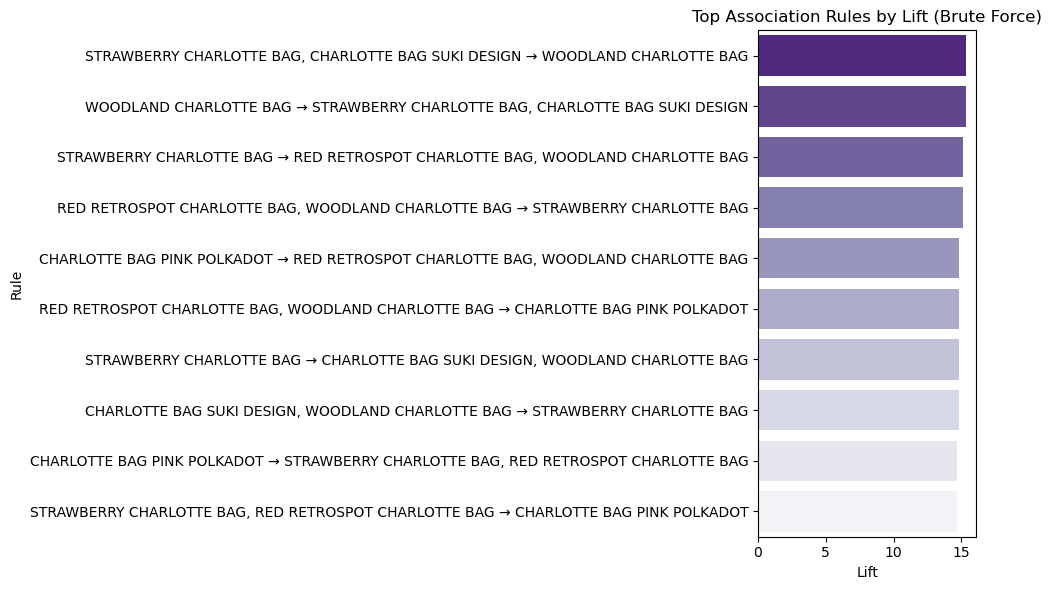

In [88]:
plt.figure(figsize=(10, 6))
sns.barplot(x='lift', y='rule', data=top_rules_brute, palette='Purples_r')
plt.title('Top Association Rules by Lift (Brute Force)')
plt.xlabel('Lift')
plt.ylabel('Rule')
plt.tight_layout()
plt.show()

##  Bubble Chart – Brute Force

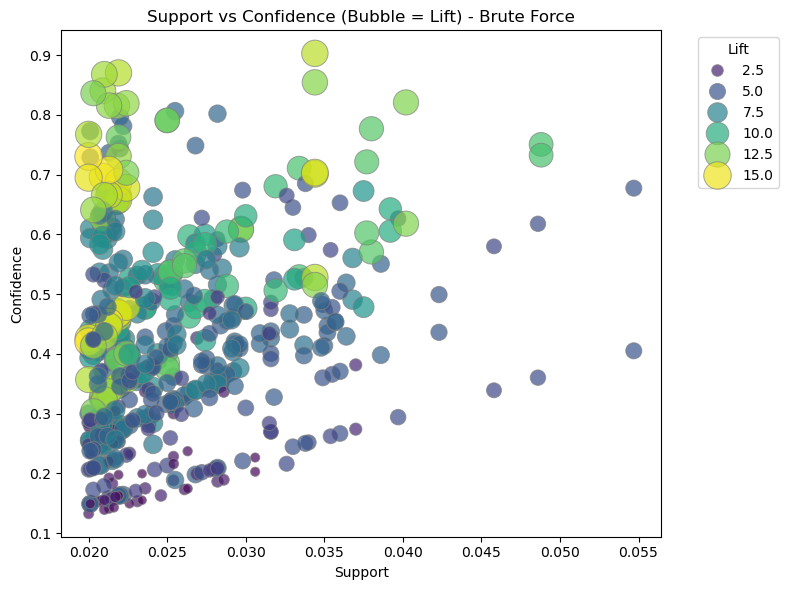

In [102]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rules_brute_df,
    x='support',
    y='confidence',
    size='lift',
    hue='lift',
    sizes=(40, 400),
    palette='viridis',
    edgecolor='gray',
    alpha=0.7
)

plt.title("Support vs Confidence (Bubble = Lift) - Brute Force")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.legend(title="Lift", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Network Graph – Brute Force


Creating Brute Force rule network graph...


C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\3867755316.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


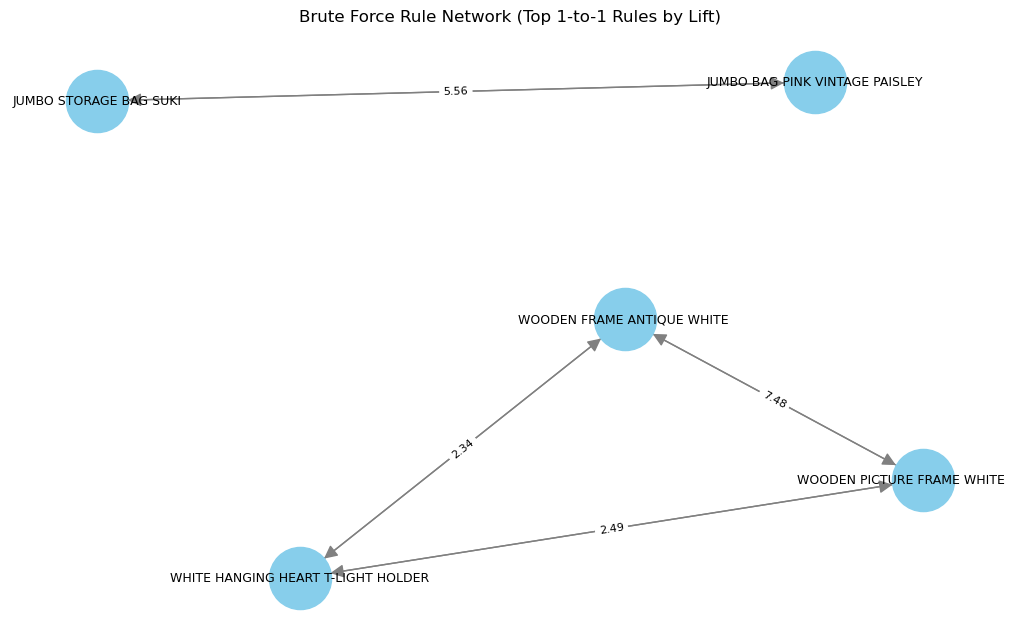

In [93]:
print("\nCreating Brute Force rule network graph:")

# Create directed graph
G = nx.DiGraph()

# Filter only simple 1-to-1 rules (top 8 for readability)
simple_rules_brute = rules_brute_df[
    (rules_brute_df['antecedents'].str.count(',') == 0) &
    (rules_brute_df['consequents'].str.count(',') == 0)
].copy().head(8)

# Add edges with lift as weight
for _, row in simple_rules_brute.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['lift'])

# Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42, k=2.5)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='skyblue',
    edge_color='gray',
    node_size=2000,
    font_size=9,
    arrowsize=20
)

# Add edge labels (lift values)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels={k: f"{v:.2f}" for k, v in labels.items()},
    font_size=8
)

plt.title("Brute Force Rule Network (Top 1-to-1 Rules by Lift)")
plt.tight_layout()
plt.show()

In [101]:
print("Top 10 Association Rules (Brute Force):")
top_brute = rules_brute_df[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(
    by='lift', ascending=False).head(10)
print(top_brute.to_string(index=False))

Top 10 Association Rules (Brute Force):
                                          antecedents                                           consequents  support  confidence    lift
  STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG SUKI DESIGN                                WOODLAND CHARLOTTE BAG   0.0200      0.7303 15.3444
                               WOODLAND CHARLOTTE BAG   STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG SUKI DESIGN   0.0200      0.4202 15.3444
                             STRAWBERRY CHARLOTTE BAG   RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOTTE BAG   0.0213      0.4532 15.0900
  RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOTTE BAG                              STRAWBERRY CHARLOTTE BAG   0.0213      0.7077 15.0900
                          CHARLOTTE BAG PINK POLKADOT   RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOTTE BAG   0.0209      0.4451 14.8206
  RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOTTE BAG                           CHARLOTTE BAG PINK POLKADOT   0.0209      0.6961 14.8206
 

# RULES COUNT OF EACH ALGORITHM (APRIORI, FP-GROWTH AND BRUTE FORCE)

In [106]:
print("Total Rules Generated:")
print(f"- Apriori     : {rules_apriori.shape[0]}")
print(f"- FP-Growth   : {rules_fp.shape[0]}")
print(f"- Brute Force : {rules_brute_df.shape[0]}")

Total Rules Generated:
- Apriori     : 190
- FP-Growth   : 209
- Brute Force : 522


## Bar Chart: Total Number of Rules

C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\3032036540.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=algo_names, y=rule_counts, palette='Set2')


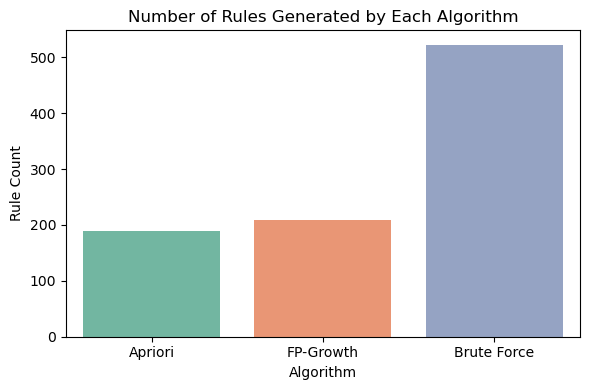

In [114]:
# Rule counts
algo_names = ['Apriori', 'FP-Growth', 'Brute Force']
rule_counts = [len(rules_apriori), len(rules_fp), len(rules_brute_df)]

plt.figure(figsize=(6, 4))
sns.barplot(x=algo_names, y=rule_counts, palette='Set2')
plt.title("Number of Rules Generated by Each Algorithm")
plt.ylabel("Rule Count")
plt.xlabel("Algorithm")
plt.tight_layout()
plt.show()

## Bar Chart: Average Lift

C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\473582875.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=algo_names, y=avg_lifts, palette='Set3')


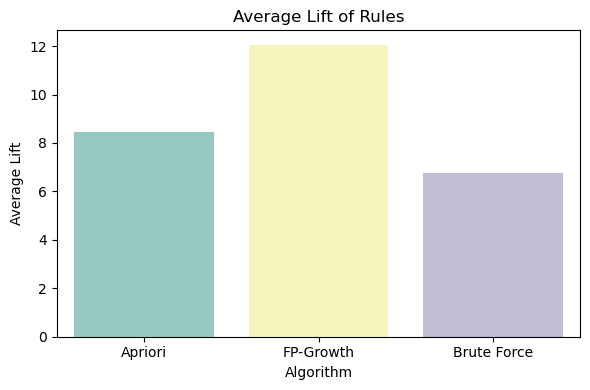

In [111]:
# Average lift
avg_lifts = [
    rules_apriori['lift'].mean(),
    rules_fp['lift'].mean(),
    rules_brute_df['lift'].mean()
]

plt.figure(figsize=(6, 4))
sns.barplot(x=algo_names, y=avg_lifts, palette='Set3')
plt.title("Average Lift of Rules")
plt.ylabel("Average Lift")
plt.xlabel("Algorithm")
plt.tight_layout()
plt.show()

## Bar Chart: Average Confidence

C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\2742842057.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=algo_names, y=avg_confidences, palette='coolwarm')


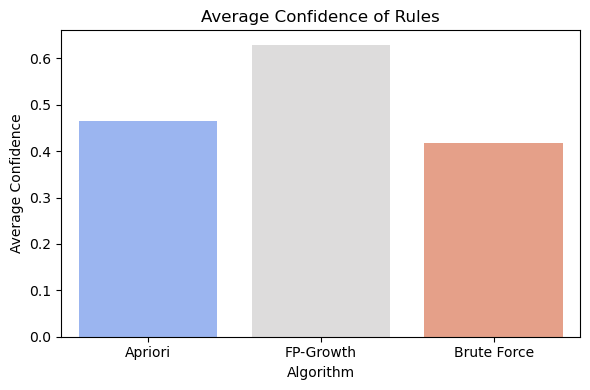

In [112]:
# Average confidence
avg_confidences = [
    rules_apriori['confidence'].mean(),
    rules_fp['confidence'].mean(),
    rules_brute_df['confidence'].mean()
]

plt.figure(figsize=(6, 4))
sns.barplot(x=algo_names, y=avg_confidences, palette='coolwarm')
plt.title("Average Confidence of Rules")
plt.ylabel("Average Confidence")
plt.xlabel("Algorithm")
plt.tight_layout()
plt.show()

## Boxplot for Lift Distribution

C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\1534622783.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=lift_df, x='Algorithm', y='Lift', palette='pastel')
C:\Users\Asus\AppData\Local\Temp\ipykernel_27856\1534622783.py:15: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
C:\Users\Asus\anaconda3\New folder\New folder\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


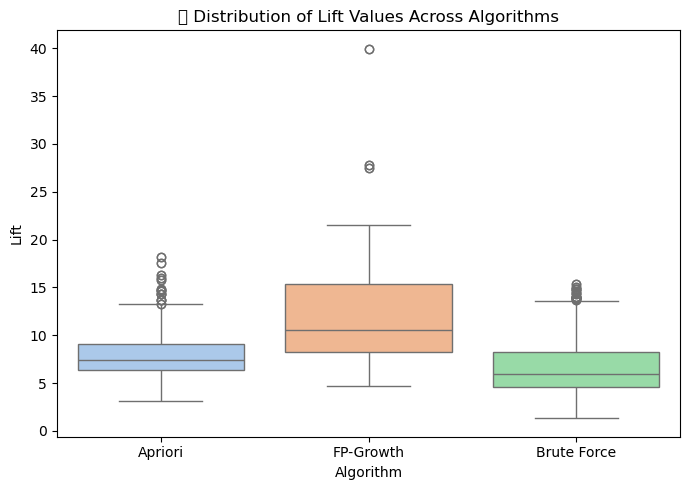

In [113]:
# Combine lift values into one DataFrame
import pandas as pd

lift_df = pd.DataFrame({
    'Lift': list(rules_apriori['lift']) + list(rules_fp['lift']) + list(rules_brute_df['lift']),
    'Algorithm': (['Apriori'] * len(rules_apriori)) + 
                 (['FP-Growth'] * len(rules_fp)) + 
                 (['Brute Force'] * len(rules_brute_df))
})

plt.figure(figsize=(7, 5))
sns.boxplot(data=lift_df, x='Algorithm', y='Lift', palette='pastel')
plt.title("🎯 Distribution of Lift Values Across Algorithms")
plt.ylabel("Lift")
plt.tight_layout()
plt.show()

In [118]:
from collections import Counter

# Extract top consequents from rules
def get_top_consequents(rules_df, top_n=5):
    all_consequents = rules_df['consequents'].apply(lambda x: list(x) if isinstance(x, frozenset) else [x])
    flat_list = [item for sublist in all_consequents for item in sublist]
    return Counter(flat_list).most_common(top_n)

print("Top Consequent Items (Recommendations)")

print("\nApriori:")
print(get_top_consequents(rules_apriori))

print("\nFP-Growth:")
print(get_top_consequents(rules_fp))

print("\nBrute Force:")
print(get_top_consequents(rules_brute_df))

Top Consequent Items (Recommendations)

Apriori:
[('JUMBO BAG RED RETROSPOT', 26), ('JUMBO STORAGE BAG SUKI', 13), ('JUMBO BAG PINK POLKADOT', 12), ('JUMBO SHOPPER VINTAGE RED PAISLEY', 12), ('LUNCH BAG RED RETROSPOT', 8)]

FP-Growth:
[('JUMBO BAG RED RETROSPOT', 26), ('JUMBO STORAGE BAG SUKI', 13), ('JUMBO BAG PINK POLKADOT', 12), ('JUMBO SHOPPER VINTAGE RED PAISLEY', 12), ('LUNCH BAG RED RETROSPOT', 8)]

Brute Force:
[('JUMBO BAG RED RETROSPOT', 39), ('LUNCH BAG RED RETROSPOT', 24), ('JUMBO STORAGE BAG SUKI', 22), ('JUMBO BAG PINK POLKADOT', 20), ('LUNCH BAG  BLACK SKULL.', 17)]
